# Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import optimizers
from keras.preprocessing import image
from keras.layers import Dropout, Flatten, Dense,BatchNormalization,Conv2D,MaxPool2D,MaxPooling2D,Activation,Conv1D
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [2]:
img_width, img_height = 128,128
# loading up datasets
train_data_dir = r'D:\Users\DELL\Desktop\fall23\cvip\DensityClasses_OneRow_Side_60VFOV_GrapevineInstanceSegmentation\train' 
test_data_dir = r'D:\Users\DELL\Desktop\fall23\cvip\DensityClasses_OneRow_Side_60VFOV_GrapevineInstanceSegmentation\test'
num_classes=4

In [3]:
batch_size = 64

# Image Augmentation

The dataset is loaded from directories containing training and testing images. Image data generators are employed for augmentation, which involves random rotations, width and height shifts, shearing, zooming, and horizontal flips. The augmentation aims to enhance the model's robustness.

In [4]:
def get_generator(path):
    generator = datagen.flow_from_directory( 
        path, 
        target_size=(img_width, img_height), 
        batch_size=batch_size, 
        class_mode="categorical", 
        shuffle=False) 

    nb_samples = len(generator.filenames)
    num_classes = len(generator.class_indices) 

    predict_size_train = int(math.ceil(nb_samples / batch_size)) 
    # get the class labels for the training data, in the original order 
    labels = generator.classes 

    # convert the training labels to categorical vectors 
    labels = to_categorical(labels, num_classes=num_classes)
    return (generator,nb_samples,predict_size_train,labels)

In [5]:
datagen = ImageDataGenerator(rescale=1. / 255) 

In [6]:
generator_train,nb_train_samples,predict_size_train,train_labels = get_generator(train_data_dir)
generator_test,nb_test_samples,predict_size_test,test_labels    = get_generator(test_data_dir)

Found 4192 images belonging to 4 classes.
Found 301 images belonging to 4 classes.


In [7]:
class_labels=list(generator_train.class_indices.keys())
print(class_labels)

['0', '100', '33', '66']


# Apply Pre-trained Model

Pretrained models such as VGGNet, GoogLeNet etc. could be very efficient for new tasks due to their learned hierarchical feature representations. They were already trained on large datasets, so these models capture generic features and complex patterns. Using these pretrained architectures improves training by initializing models with knowledge from diverse data. This approach is especially beneficial when limited labeled data is available for a specific task, as the models offer generalized knowledge

In [8]:
def apply_pretrainedModel(pretrained_model,generator,predict_size):
    return pretrained_model.predict(generator, predict_size) 

# Apply transfer Learning

Transfer learning is applied using different pre-trained models: VGG16, InceptionV3, ResNet50, Xception, InceptionResNetV2, MobileNetV2. In Transfer learning, we use pre-trained models, which have learnt general features from a large dataset (like ImageNet), serves as a foundation. To use it for grapevine leaf density estimation task, we remove its task-specific layers and append new layers tailored to our target task. This enables the model to retain knowledge about low-level features and adapt to the nuances of the grapevine leaf density estimation problem at hand. In our code the last layers of these models are removed, The top layers are then replaced with a custom fully connected layer / classifier for grapevine leaf density estimation leveraging the knowledge derived by pretrained model from previous layers.

**cnn_after_pretrainedModel function** is an important function in the transfer learning process. It takes a pre-trained convolutional neural network (CNN) model, and modifies it for our task. By removing the task-specific layers and appending our own fully connected layer/output layer tailered to our grapevine leaf density estimation problem with appropriate loss and activation function.

**transfer_learning function** initializes the pre-trained model and then applies the transfer learning by calling the cnn_after_pretrainedModel function as it appends tailored fully connected layer / output layer and then using this model we train the data on our train_images and then we evaluate the model to capture performance metrics

**plot_graphs** visualizes training and validation metrics over epochs, providing insights into the model's performance.

In [9]:
def cnn_after_pretrainedModel(input_shape):
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape)) 
    model.add(Dense(256, activation='relu'))  # Increase units and use ReLU
    model.add(Dropout(0.5)) 
    model.add(Dense(128, activation='relu'))  # Increase units and use ReLU
    #model.add(BatchNormalization())
    model.add(Dropout(0.3)) 
    model.add(Dense(num_classes, activation='softmax'))
    
    # Use a different optimizer and experiment with learning rate
    optimizer = optimizers.Adam(lr=1e-4)

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])  # 'accuracy' is equivalent to 'acc'

    return model

In [10]:
def transfer_learning(pretrained_model,epochs=34):
    #Appling Pretrained Model to train and test datasets
    train_data = apply_pretrainedModel(pretrained_model,generator_train,predict_size_train)
    test_data  = apply_pretrainedModel(pretrained_model,generator_test,predict_size_test)
    model      = cnn_after_pretrainedModel(train_data.shape[1:])
    history = model.fit(train_data, train_labels, 
       epochs=epochs,
       batch_size=batch_size, 
       validation_data=(test_data, test_labels))
    (eval_loss, eval_accuracy) = model.evaluate( 
        test_data, test_labels, batch_size=batch_size,     verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
    print("[INFO] Loss: {}".format(eval_loss))
    
    return train_data,test_data,model,history,eval_accuracy

In [11]:
def plot_graphs(history, model_name):
    #Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Test acc')
    plt.title(f'Training and Testing accuracy for {model_name}')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Testing loss')
    plt.title('Training and Testing loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# Build Model  VGG

We are initializing VGG16 model with pre-trained ImageNet weights, leveraging its learned features and then we initialize the transfer learning process, adapting the VGG16 model to our grapevine leaf density estimation task, training it on provided data, and storing relevant information such as the model itself, training history, and accuracy metrics, include_top = False hyperparameter excludes the fully connected layers (top layers) of the pre-trained model. This allows us to add and customize our own fully connected layers or output layers based on the specific requirements of our target task. 

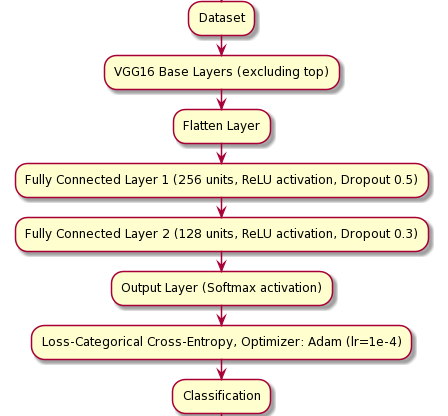

In [33]:
model_name = "VGG"
pretrained_model_vgg = applications.VGG16(include_top=False, weights='imagenet')
train_data, test_data, model_vgg, history_vgg, acc_vgg = transfer_learning(pretrained_model_vgg)
print()

5/5 [==============================] - 31s 5s/step
Epoch 1/34


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


66/66 [==============================] - 2s 22ms/step - loss: 1.4264 - acc: 0.2891 - val_loss: 1.3120 - val_acc: 0.3987
Epoch 2/34
66/66 [==============================] - 1s 18ms/step - loss: 1.3140 - acc: 0.3655 - val_loss: 1.2540 - val_acc: 0.4618
Epoch 3/34
66/66 [==============================] - 1s 19ms/step - loss: 1.2373 - acc: 0.4098 - val_loss: 1.1156 - val_acc: 0.4850
Epoch 4/34
66/66 [==============================] - 1s 19ms/step - loss: 1.1566 - acc: 0.4635 - val_loss: 1.0127 - val_acc: 0.5648
Epoch 5/34
66/66 [==============================] - 1s 18ms/step - loss: 1.0900 - acc: 0.5014 - val_loss: 0.9757 - val_acc: 0.5714
Epoch 6/34
66/66 [==============================] - 1s 18ms/step - loss: 1.0228 - acc: 0.5327 - val_loss: 0.9231 - val_acc: 0.5581
Epoch 7/34
66/66 [==============================] - 1s 18ms/step - loss: 0.9699 - acc: 0.5642 - val_loss: 0.8090 - val_acc: 0.6844
Epoch 8/34
66/66 [==============================] - 1s 19ms/step - loss: 0.9337 - acc: 0.5747 

# Visualise VGG training and testing

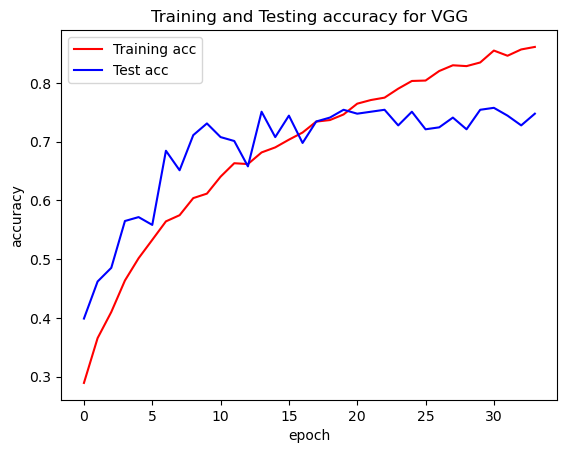

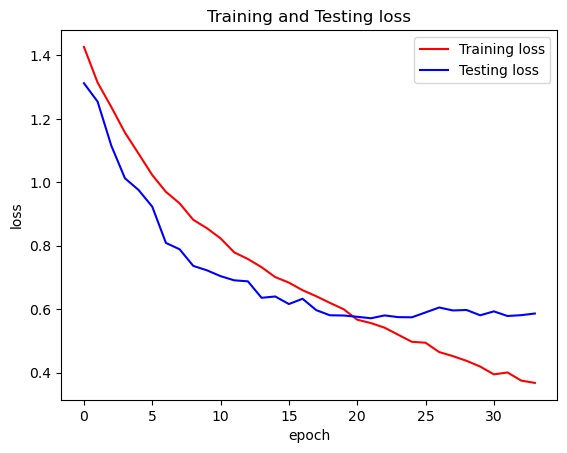

10/10 [==============================] - 0s 8ms/step


In [35]:
plot_graphs(history_vgg,'VGG')
#print(test_data)
preds_vgg=np.round(model_vgg.predict(test_data),0)

# Performance Metrics

In [14]:
X_test = test_data

# Make predictions
y_pred_probs = model_vgg.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(test_labels, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(metrics.classification_report(y_true, y_pred))


10/10 [==============================] - 0s 4ms/step
Confusion Matrix:
[[66  0 10  0]
 [ 0 66  0  9]
 [10  2 52 11]
 [ 0 33 10 32]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        76
           1       0.65      0.88      0.75        75
           2       0.72      0.69      0.71        75
           3       0.62      0.43      0.50        75

    accuracy                           0.72       301
   macro avg       0.71      0.72      0.71       301
weighted avg       0.72      0.72      0.71       301



## Applying GOOGLE NET 

We are initializing InceptionV3 model with pre-trained ImageNet weights, leveraging its learned features and then we initialize the transfer learning process, adapting the InceptionV3 model to our grapevine leaf density estimation task, training it on provided data, and storing relevant information such as the model itself, training history, and accuracy metrics, include_top = False hyperparameter excludes the fully connected layers (top layers) of the pre-trained model. This allows us to add and customize our own fully connected layers or output layers based on the specific requirements of our target task. 

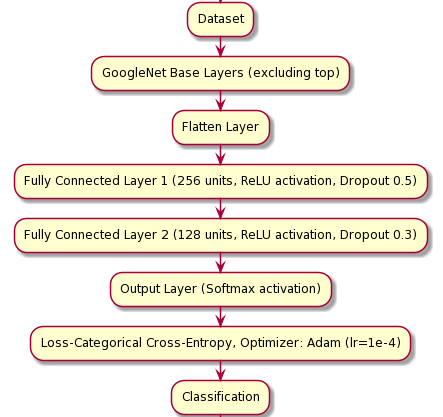

In [15]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_googleNet  = applications.InceptionV3(include_top=False, weights='imagenet')
train_data,test_data,model_googleNet,history_googleNet,acc_googleNet = transfer_learning(pretrained_model_googleNet)

5/5 [==============================] - 18s 3s/step
Epoch 1/34


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


66/66 [==============================] - 2s 22ms/step - loss: 1.6620 - acc: 0.2867 - val_loss: 1.3015 - val_acc: 0.3821
Epoch 2/34
66/66 [==============================] - 1s 19ms/step - loss: 1.3314 - acc: 0.3581 - val_loss: 1.2225 - val_acc: 0.4651
Epoch 3/34
66/66 [==============================] - 1s 19ms/step - loss: 1.2507 - acc: 0.4082 - val_loss: 1.1268 - val_acc: 0.4950
Epoch 4/34
66/66 [==============================] - 1s 19ms/step - loss: 1.1989 - acc: 0.4198 - val_loss: 1.0433 - val_acc: 0.5183
Epoch 5/34
66/66 [==============================] - 1s 19ms/step - loss: 1.1556 - acc: 0.4532 - val_loss: 1.0128 - val_acc: 0.5415
Epoch 6/34
66/66 [==============================] - 1s 19ms/step - loss: 1.0895 - acc: 0.4888 - val_loss: 1.0252 - val_acc: 0.4585
Epoch 7/34
66/66 [==============================] - 1s 19ms/step - loss: 1.0550 - acc: 0.5012 - val_loss: 0.9928 - val_acc: 0.5150
Epoch 8/34
66/66 [==============================] - 1s 19ms/step - loss: 1.0204 - acc: 0.5260 

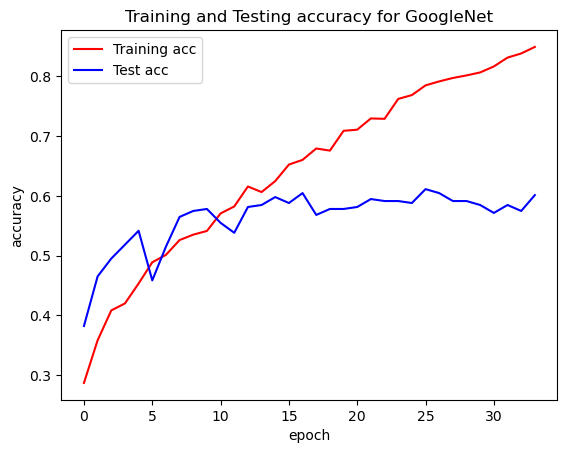

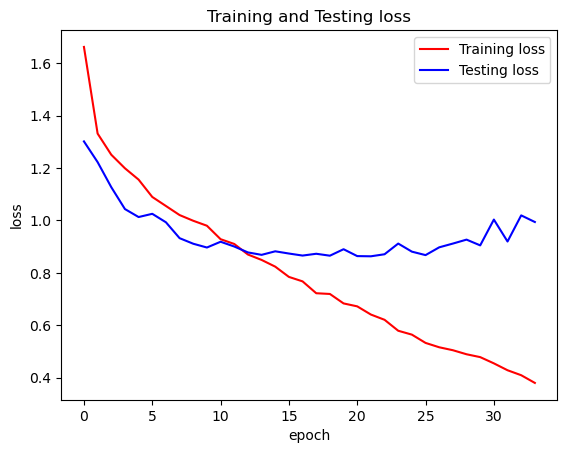

10/10 [==============================] - 0s 4ms/step


In [16]:
plot_graphs(history_googleNet,'GoogleNet')
preds_googlenet=np.round(model_googleNet.predict(test_data),0)
#preds_googlenet

In [17]:
X_test = test_data

# Make predictions
y_pred_probs = model_googleNet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(test_labels, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(metrics.classification_report(y_true, y_pred))


10/10 [==============================] - 0s 4ms/step
Confusion Matrix:
[[50  0 25  1]
 [ 0 59  1 15]
 [14 11 37 13]
 [ 1 31  8 35]]

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.66      0.71        76
           1       0.58      0.79      0.67        75
           2       0.52      0.49      0.51        75
           3       0.55      0.47      0.50        75

    accuracy                           0.60       301
   macro avg       0.61      0.60      0.60       301
weighted avg       0.61      0.60      0.60       301



# ResNet

We are initializing ResNet model with pre-trained ImageNet weights, leveraging its learned features and then we initialize the transfer learning process, adapting the ResNet model to our grapevine leaf density estimation task, training it on provided data, and storing relevant information such as the model itself, training history, and accuracy metrics, include_top = False hyperparameter excludes the fully connected layers (top layers) of the pre-trained model. This allows us to add and customize our own fully connected layers or output layers based on the specific requirements of our target task. 

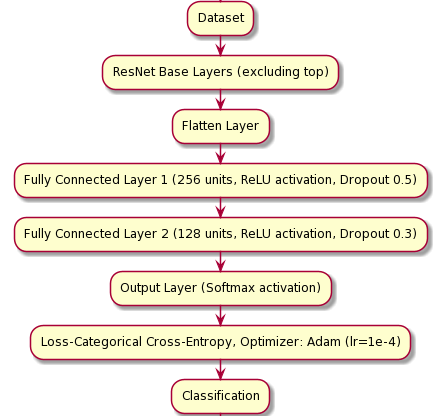

In [18]:
#Loading Pre-trained Model
model_name="RES NET"
pretrained_model_resNet  = applications.ResNet152(include_top=False, weights='imagenet')
train_data,test_data,model_resNet,history_resNet,acc_resNet= transfer_learning(pretrained_model_resNet)

5/5 [==============================] - 33s 6s/step
Epoch 1/34


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


66/66 [==============================] - 5s 71ms/step - loss: 1.4195 - acc: 0.2588 - val_loss: 1.3860 - val_acc: 0.2591
Epoch 2/34
66/66 [==============================] - 4s 63ms/step - loss: 1.3962 - acc: 0.2533 - val_loss: 1.3861 - val_acc: 0.2425
Epoch 3/34
66/66 [==============================] - 4s 61ms/step - loss: 1.3891 - acc: 0.2564 - val_loss: 1.3864 - val_acc: 0.2558
Epoch 4/34
66/66 [==============================] - 4s 61ms/step - loss: 1.3873 - acc: 0.2531 - val_loss: 1.3875 - val_acc: 0.2425
Epoch 5/34
66/66 [==============================] - 4s 62ms/step - loss: 1.3871 - acc: 0.2467 - val_loss: 1.3866 - val_acc: 0.2558
Epoch 6/34
66/66 [==============================] - 4s 67ms/step - loss: 1.3868 - acc: 0.2548 - val_loss: 1.3858 - val_acc: 0.2492
Epoch 7/34
66/66 [==============================] - 4s 67ms/step - loss: 1.3852 - acc: 0.2595 - val_loss: 1.3877 - val_acc: 0.2492
Epoch 8/34
66/66 [==============================] - 4s 65ms/step - loss: 1.3874 - acc: 0.2462 

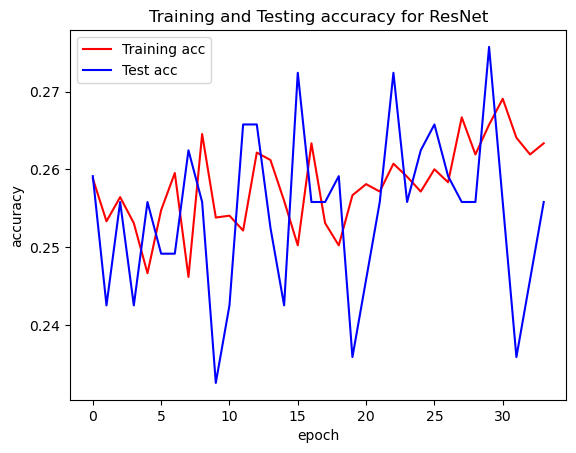

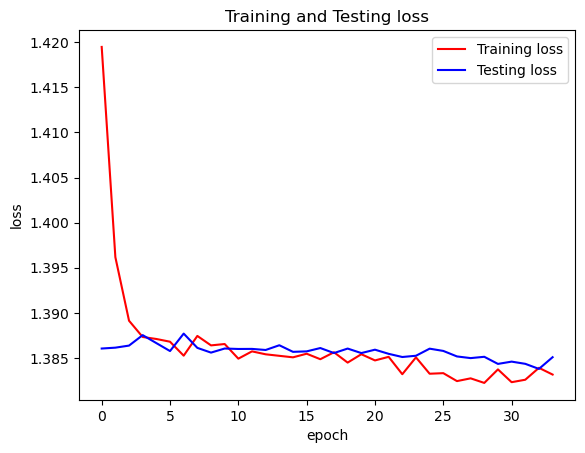

10/10 [==============================] - 0s 13ms/step


In [19]:
plot_graphs(history_resNet,'ResNet')
preds_resnet=np.round(model_resNet.predict(test_data),0)
# print(preds_resnet)
# print(preds_resnet[0].shape)

In [20]:
X_test = test_data

# Make predictions
y_pred_probs = model_resNet.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(test_labels, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("\nClassification Report:")
print(metrics.classification_report(y_true, y_pred))


10/10 [==============================] - 0s 12ms/step
Confusion Matrix:
[[51 25  0  0]
 [49 26  0  0]
 [54 21  0  0]
 [49 26  0  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.67      0.37        76
           1       0.27      0.35      0.30        75
           2       0.00      0.00      0.00        75
           3       0.00      0.00      0.00        75

    accuracy                           0.26       301
   macro avg       0.13      0.25      0.17       301
weighted avg       0.13      0.26      0.17       301



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Xception

We are initializing Xception model with pre-trained ImageNet weights, leveraging its learned features and then we initialize the transfer learning process, adapting the Xception model to our grapevine leaf density estimation task, training it on provided data, and storing relevant information such as the model itself, training history, and accuracy metrics, include_top = False hyperparameter excludes the fully connected layers (top layers) of the pre-trained model. This allows us to add and customize our own fully connected layers or output layers based on the specific requirements of our target task. 

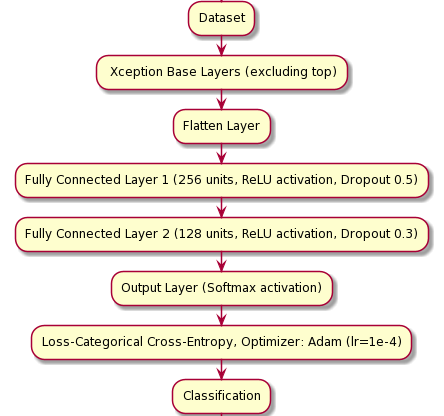

In [21]:
# Loading Pre-trained Model (Xception)
pretrained_model_xception = applications.Xception(include_top=False, weights='imagenet')

# Transfer Learning
train_data_xception, test_data_xception, model_xception, history_xception, acc_xception = transfer_learning(
    pretrained_model_xception)


5/5 [==============================] - 21s 4s/step
Epoch 1/34


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


66/66 [==============================] - 7s 65ms/step - loss: 1.3585 - acc: 0.3445 - val_loss: 1.1868 - val_acc: 0.4352
Epoch 2/34
66/66 [==============================] - 4s 62ms/step - loss: 1.1987 - acc: 0.4432 - val_loss: 1.1252 - val_acc: 0.4585
Epoch 3/34
66/66 [==============================] - 4s 62ms/step - loss: 1.1464 - acc: 0.4571 - val_loss: 1.0491 - val_acc: 0.4884
Epoch 4/34
66/66 [==============================] - 4s 62ms/step - loss: 1.0907 - acc: 0.4766 - val_loss: 1.0217 - val_acc: 0.5017
Epoch 5/34
66/66 [==============================] - 4s 62ms/step - loss: 1.0407 - acc: 0.5072 - val_loss: 1.0105 - val_acc: 0.5249
Epoch 6/34
66/66 [==============================] - 4s 64ms/step - loss: 1.0013 - acc: 0.5246 - val_loss: 0.9959 - val_acc: 0.5083
Epoch 7/34
66/66 [==============================] - 4s 63ms/step - loss: 0.9600 - acc: 0.5510 - val_loss: 0.9477 - val_acc: 0.5581
Epoch 8/34
66/66 [==============================] - 4s 63ms/step - loss: 0.9237 - acc: 0.5711 

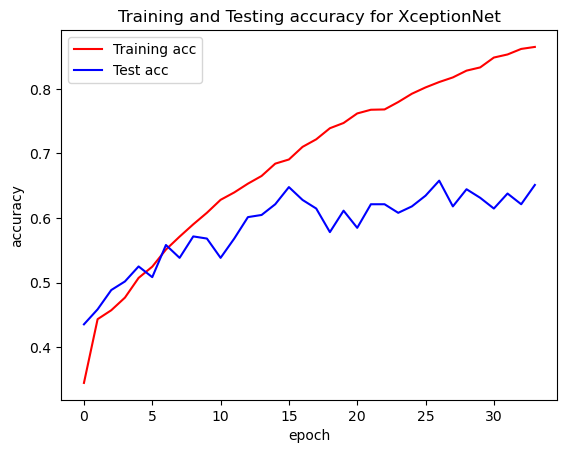

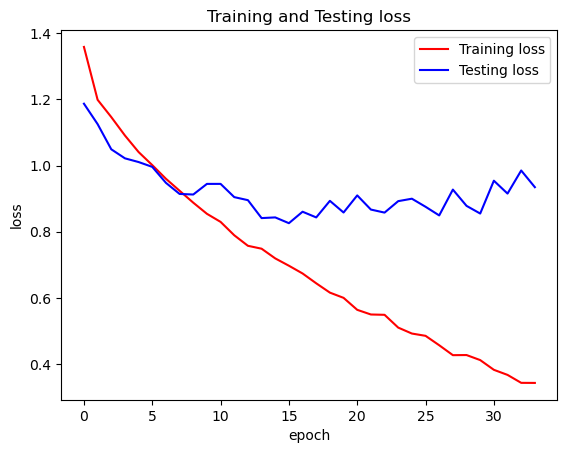

10/10 [==============================] - 0s 10ms/step


In [22]:
# Plot graphs and print test_data
plot_graphs(history_xception, 'XceptionNet')
#print(test_data_xception)

# Calculate predictions
preds_xception = np.round(model_xception.predict(test_data_xception), 0)

In [23]:
classify_matrics_xception=metrics.classification_report(test_labels,preds_xception,target_names=class_labels)
print(classify_matrics_xception)

              precision    recall  f1-score   support

           0       0.81      0.88      0.84        76
         100       0.64      0.72      0.67        75
          33       0.68      0.48      0.56        75
          66       0.57      0.43      0.49        75

   micro avg       0.68      0.63      0.65       301
   macro avg       0.67      0.63      0.64       301
weighted avg       0.67      0.63      0.64       301
 samples avg       0.63      0.63      0.63       301



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# InceptionResnetV2

We are initializing InceptionResNetV2 model with pre-trained ImageNet weights, leveraging its learned features and then we initialize the transfer learning process, adapting the InceptionResnetV2 model to our grapevine leaf density estimation task, training it on provided data, and storing relevant information such as the model itself, training history, and accuracy metrics, include_top = False hyperparameter excludes the fully connected layers (top layers) of the pre-trained model. This allows us to add and customize our own fully connected layers or output layers based on the specific requirements of our target task. 

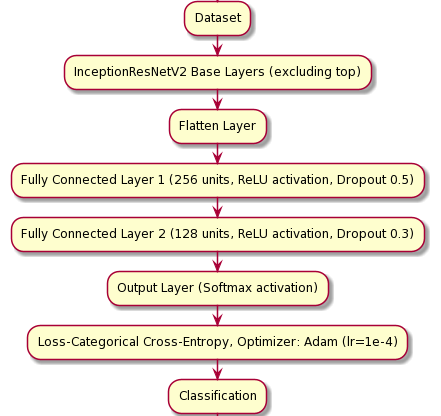

In [24]:
# Loading Pre-trained Model (InceptionResNetV2)
pretrained_model_inceptionresnetv2 = applications.InceptionResNetV2(include_top=False, weights='imagenet')

# Transfer Learning
train_data_inceptionresnetv2, test_data_inceptionresnetv2, model_inceptionresnetv2, history_inceptionresnetv2, acc_inceptionresnetv2 = transfer_learning(
    pretrained_model_inceptionresnetv2)

5/5 [==============================] - 22s 4s/step
Epoch 1/34


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


66/66 [==============================] - 2s 19ms/step - loss: 1.5682 - acc: 0.3082 - val_loss: 1.2280 - val_acc: 0.4485
Epoch 2/34
66/66 [==============================] - 1s 17ms/step - loss: 1.3065 - acc: 0.3740 - val_loss: 1.1488 - val_acc: 0.4618
Epoch 3/34
66/66 [==============================] - 1s 17ms/step - loss: 1.2142 - acc: 0.4318 - val_loss: 1.0894 - val_acc: 0.4917
Epoch 4/34
66/66 [==============================] - 1s 18ms/step - loss: 1.1492 - acc: 0.4552 - val_loss: 0.9989 - val_acc: 0.5449
Epoch 5/34
66/66 [==============================] - 1s 18ms/step - loss: 1.0956 - acc: 0.4826 - val_loss: 0.9527 - val_acc: 0.5947
Epoch 6/34
66/66 [==============================] - 1s 17ms/step - loss: 1.0575 - acc: 0.5052 - val_loss: 0.9324 - val_acc: 0.6312
Epoch 7/34
66/66 [==============================] - 1s 18ms/step - loss: 1.0229 - acc: 0.5253 - val_loss: 0.9101 - val_acc: 0.6113
Epoch 8/34
66/66 [==============================] - 1s 17ms/step - loss: 0.9775 - acc: 0.5515 

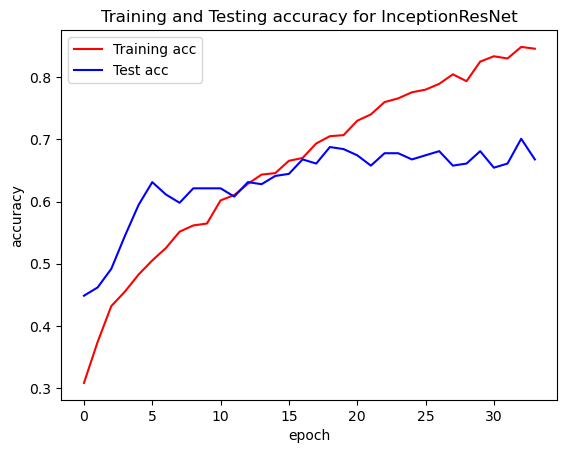

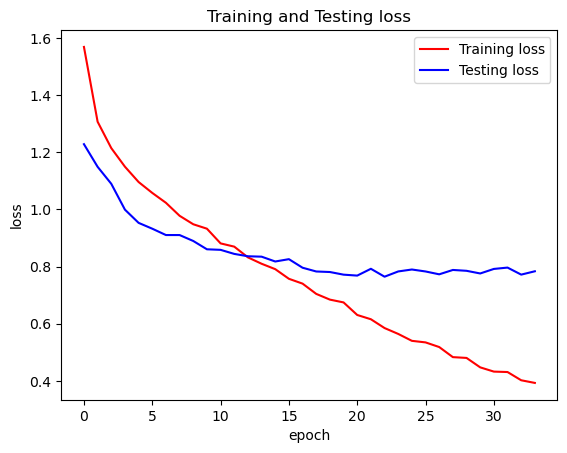

10/10 [==============================] - 0s 4ms/step


In [25]:
# Plot graphs and print test_data
plot_graphs(history_inceptionresnetv2, 'InceptionResNet')
#print(test_data_inceptionresnetv2)

# Calculate predictions
preds_inceptionresnetv2 = np.round(model_inceptionresnetv2.predict(test_data_inceptionresnetv2), 0)

In [26]:
classify_matrics_inceptionresnetv2=metrics.classification_report(test_labels,preds_inceptionresnetv2,target_names=class_labels)
print(classify_matrics_inceptionresnetv2)

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        76
         100       0.77      0.64      0.70        75
          33       0.62      0.49      0.55        75
          66       0.55      0.63      0.58        75

   micro avg       0.68      0.64      0.66       301
   macro avg       0.69      0.64      0.66       301
weighted avg       0.69      0.64      0.66       301
 samples avg       0.64      0.64      0.64       301



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# MobileNetV2

We are initializing MobileNetV2 model with pre-trained ImageNet weights, leveraging its learned features and then we initialize the transfer learning process, adapting the MobileNetV2 model to our grapevine leaf density estimation task, training it on provided data, and storing relevant information such as the model itself, training history, and accuracy metrics, include_top = False hyperparameter excludes the fully connected layers (top layers) of the pre-trained model. This allows us to add and customize our own fully connected layers or output layers based on the specific requirements of our target task. 

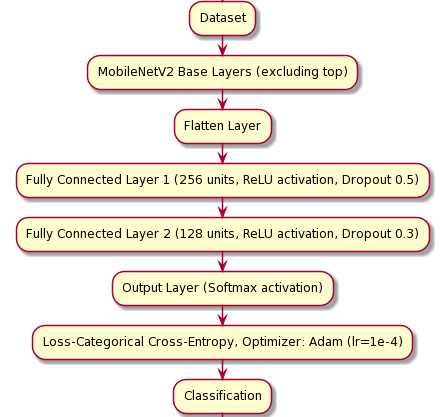

In [27]:
# Loading Pre-trained Model (MobileNetV2)
pretrained_model_mobilenetv2 = applications.MobileNetV2(include_top=False, weights='imagenet')

# Transfer Learning
train_data_mobilenetv2, test_data_mobilenetv2, model_mobilenetv2, history_mobilenetv2, acc_mobilenetv2 = transfer_learning(
    pretrained_model_mobilenetv2)

5/5 [==============================] - 16s 3s/step
Epoch 1/34


C:\Users\DELL\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


66/66 [==============================] - 3s 45ms/step - loss: 1.6211 - acc: 0.3306 - val_loss: 1.1026 - val_acc: 0.5150
Epoch 2/34
66/66 [==============================] - 3s 41ms/step - loss: 1.1890 - acc: 0.4475 - val_loss: 0.9313 - val_acc: 0.5814
Epoch 3/34
66/66 [==============================] - 3s 42ms/step - loss: 1.0576 - acc: 0.5129 - val_loss: 0.8171 - val_acc: 0.6047
Epoch 4/34
66/66 [==============================] - 3s 42ms/step - loss: 0.9837 - acc: 0.5496 - val_loss: 0.7873 - val_acc: 0.6047
Epoch 5/34
66/66 [==============================] - 3s 43ms/step - loss: 0.8937 - acc: 0.5847 - val_loss: 0.7373 - val_acc: 0.6645
Epoch 6/34
66/66 [==============================] - 3s 43ms/step - loss: 0.8472 - acc: 0.6121 - val_loss: 0.7260 - val_acc: 0.6977
Epoch 7/34
66/66 [==============================] - 3s 42ms/step - loss: 0.7659 - acc: 0.6493 - val_loss: 0.6894 - val_acc: 0.6246
Epoch 8/34
66/66 [==============================] - 3s 43ms/step - loss: 0.7447 - acc: 0.6586 

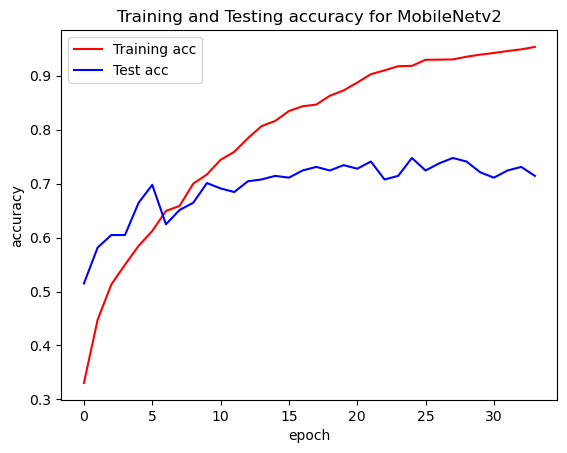

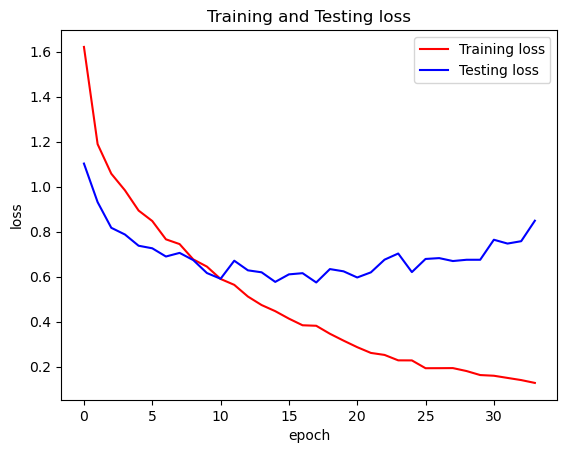

10/10 [==============================] - 0s 8ms/step


In [28]:
# Plot graphs and print test_data
plot_graphs(history_mobilenetv2,'MobileNetv2')
#print(test_data_mobilenetv2)

# Calculate predictions
preds_mobilenetv2 = np.round(model_mobilenetv2.predict(test_data_mobilenetv2), 0)

In [29]:
classify_matrics_mobilenetv2 =metrics.classification_report(test_labels,preds_mobilenetv2,target_names=class_labels)
print(classify_matrics_mobilenetv2)

              precision    recall  f1-score   support

           0       0.85      1.00      0.92        76
         100       0.65      0.80      0.72        75
          33       0.85      0.61      0.71        75
          66       0.52      0.43      0.47        75

   micro avg       0.72      0.71      0.72       301
   macro avg       0.72      0.71      0.71       301
weighted avg       0.72      0.71      0.71       301
 samples avg       0.71      0.71      0.71       301



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Comparing Models

In [37]:
print("Accuracies of Models")
print("VGG\t\t\t",acc_vgg)
print("Google Net\t\t",acc_googleNet)
print("ResNet\t\t\t",acc_resNet)
print("MobileNet\t\t",acc_mobilenetv2)
print("Xception\t\t",acc_xception)
print("InceptionResnetV2\t",acc_inceptionresnetv2)

Accuracies of Models
VGG			 0.7475082874298096
Google Net		 0.6013289093971252
ResNet			 0.25581395626068115
MobileNet		 0.7142857313156128
Xception		 0.6511628031730652
InceptionResnetV2	 0.6677740812301636


# Testing a Single Image

In [31]:
import cv2
import numpy as np
from PIL import Image

def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = cv2.imread(file_path)

    # Check if the image has an alpha channel (4 channels)
    if image.shape[2] == 4:
        image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)

    # Resize the image
    image = cv2.resize(image, (img_width, img_height))
    
    # Normalize the pixel values
    image = image / 255.0
    
    # Add an extra dimension to match the expected input shape
    image = np.expand_dims(image, axis=0)
    
    return image

[INFO] loading and preprocessing image…
1/1 [==============================] - 0s 47ms/step
ID: 0, Label: 0 0.0%
ID: 1, Label: 100 93.4%
ID: 2, Label: 33 0.0%
Final Decision:
.
..
...
1/1 [==============================] - 0s 71ms/step
ID: 1, Label: 100


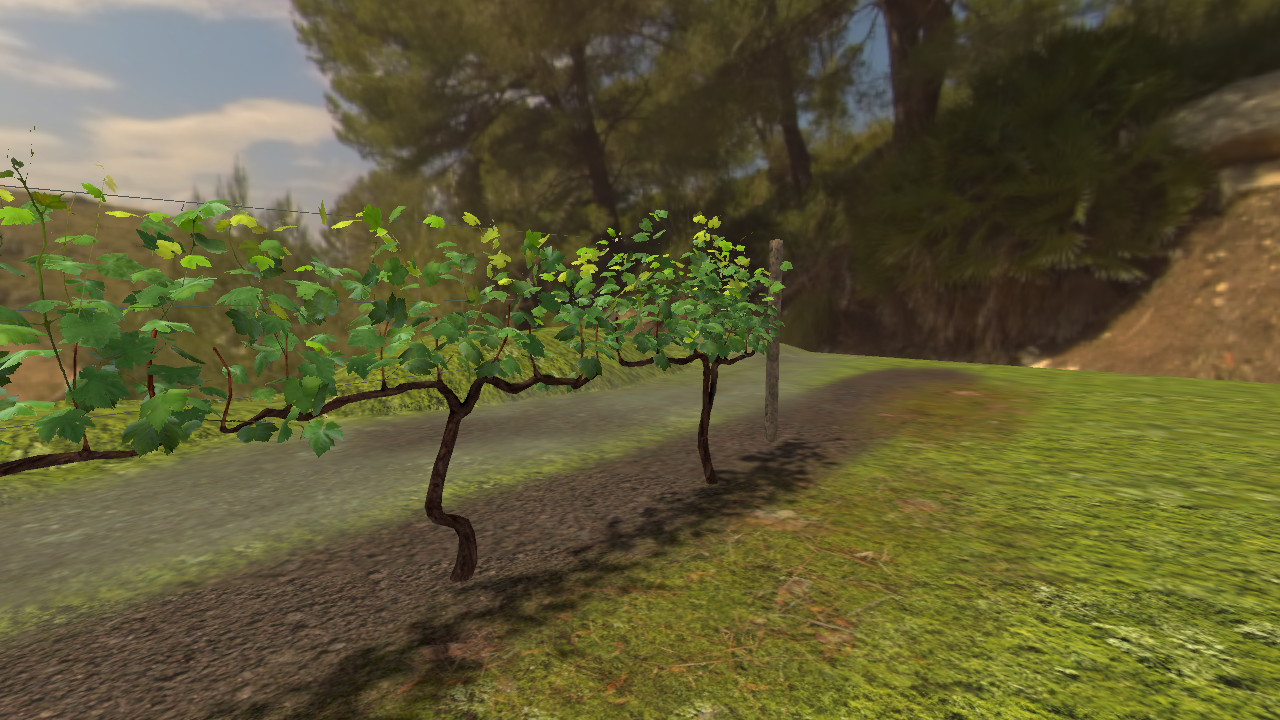

In [40]:
def test_single_image(pretrained_model,model,path):
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = pretrained_model.predict(images) 
    preds = model.predict(bt_prediction)
    for idx, animal, x in zip(range(0,3), class_labels , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict(bt_prediction)
    predicted_classes = np.argmax(class_predicted, axis=1)
    class_dictionary = generator_test.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    # Display the final predicted class
    print("ID: {}, Label: {}".format(predicted_classes[0], inv_map[predicted_classes[0]]))

    # Return the image for display or further processing
    return Image.open(path)
path = r'D:\Users\DELL\Desktop\fall23\cvip\DensityClasses_OneRow_Side_60VFOV_GrapevineInstanceSegmentation\test\100\rgb_187.png'
test_single_image(pretrained_model_vgg,model_vgg,path)

# END